<a href="https://colab.research.google.com/github/Brunoxue/hsi_examples/blob/main/create_tite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creation of a Synthetic Hyperspectral Dataset for Target Implantation and Embeddedness using Python

In this demo project, we will demostrate how to use endmembers from Cuprite hyperspectral imagery to create Target Inplantation (TI) and Target Embeddedness (TI) synthetic hyperspectral imagery with Python.

## 1. Download Endmembers and Load Packages

In [6]:
# Get endmembers from Github repo
!git clone https://github.com/Brunoxue/tite.git

# Load Packages
import matplotlib.pyplot as plt
from scipy.io import loadmat,savemat
import numpy as np

## 2.Read Target Spectra (Endmembers)

This demo project use the endmembers taken from Cuprite reflectance hyperspectral data to form synthetic hyperpsectral TI and TE dataset. First, we can load the variables from the cuprite_minerals_spectra_reflectance.mat file into the Python environment.

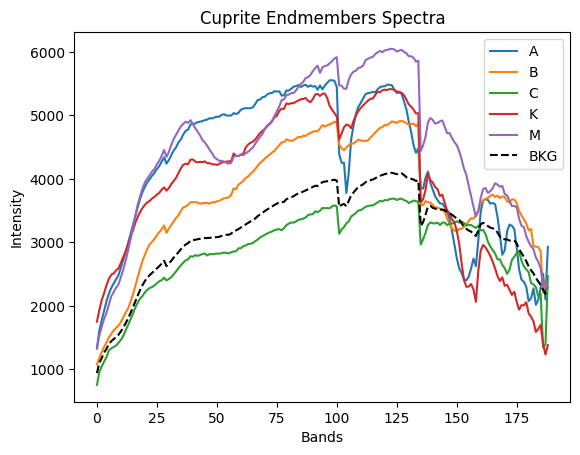

In [5]:
# Load the .mat file
data = loadmat('tite/cuprite_minerals_spectra_reflectance.mat')

# Extract the variables
minerals = data['minerals']
background = data['background']
minerals_label = data['minerals_label']

# Plot the data
plt.figure()
for i in range(minerals.shape[1]):
    plt.plot(minerals[:, i], label=f'Mineral {i+1}')
plt.plot(background, label='Background', linestyle='--', color='black')

plt.title("Cuprite Endmembers Spectra")
plt.xlabel("Bands")
plt.ylabel("Intensity")
plt.legend(["A", "B", "C", "K", "M", "BKG"])
plt.show()

## 3. Create TI and TE datasets

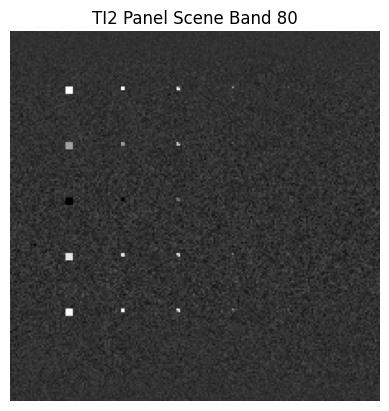

In [10]:
# Function for creating TI and TE datasets
def six_scenarios(M, BKG):
    # Function six_scenarios for creating TI and TE datasets
    # Composed by Hsiao-Chi Li
    # Modified by Bai Xue

    L, p = M.shape
    GT = np.zeros((200, 200))
    BKG=BKG.squeeze()

    # Simulated white Gaussian noise
    snr = 20
    sigma = 0.5 * BKG / snr
    noise = np.reshape(np.repeat(sigma, 200 * 200).reshape(200, 200, L) * np.random.randn(200, 200, L), (200, 200, L))

    # Scenario 1: Clean target, clean background
    ImageCub = np.reshape(np.repeat(BKG, 200 * 200).reshape(L,200*200).T, (200, 200, L))

    for k in range(5):  # Each row, one endmember will be the main endmember
        d = M[:, k]  # 1:Alunite, 2:Buddingtonite, 3:Calcite, 4:Kaolinite, 5:Muscovite

        # Pure pixels in column 1 (4x4)
        j = 0
        for m in range(4):
            for n in range(4):
                ImageCub[30 + 30 * k + m, 30 + 30 * j + n, :] = d
                GT[30 + 30 * k + m, 30 + 30 * j + n] = 1

        # Pure pixels in column 2 (2x2)
        j = 1
        for m in range(2):
            for n in range(2):
                ImageCub[30 + 30 * k + m, 30 + 30 * j + n, :] = d
                GT[30 + 30 * k + m, 30 + 30 * j + n] = 1

        # Mixed pixel in column 3 (50% of 2 endmembers, 2x2)
        U = np.delete(M, k, axis=1)
        M1 = 0.5 * (np.repeat(d[:, np.newaxis], 4, axis=1) + U)
        j = 2
        for m in range(2):
            for n in range(2):
                ImageCub[30 + 30 * k + m, 30 + 30 * j + n, :] = M1[:, 2 * m + n]
                GT[30 + 30 * k + m, 30 + 30 * j + n] = 1

        # Mixed pixel in column 4 (50% of endmember + 50% of Background, 1x1)
        j = 3
        ImageCub[30 + 30 * k, 30 + 30 * j, :] = 0.5 * d + 0.5 * BKG
        GT[30 + 30 * k, 30 + 30 * j] = 1

        # Mixed pixel in column 5 (25% of endmember + 75% of Background, 1x1)
        j = 4
        ImageCub[30 + 30 * k, 30 + 30 * j, :] = 0.25 * d + 0.75 * BKG
        GT[30 + 30 * k, 30 + 30 * j] = 1

    TI1 = ImageCub

    # Scenario 2: Clean target, noisy background
    noise1 = noise
    for i in range(L):
        noise1[:,:,i] = noise1[:,:,i] * (1 - GT)
    TI2 = ImageCub + noise1  # Add noise

    # Scenario 3: Noisy target, noisy background
    TI3 = ImageCub + noise  # Add noise to whole scene

    # Scenario 4: Embedded clean target, clean background
    ImageCub = np.reshape(np.repeat(BKG, 200 * 200).reshape(L,200*200).T, (200, 200, L))

    for k in range(5):
        d = M[:, k]
        j = 0
        for m in range(4):
            for n in range(4):
                ImageCub[30 + 30 * k + m, 30 + 30 * j + n, :] = BKG + d

        j = 1
        for m in range(2):
            for n in range(2):
                ImageCub[30 + 30 * k + m, 30 + 30 * j + n, :] = BKG + d

        U = np.delete(M, k, axis=1)
        M1 = 0.5 * (np.repeat(d[:, np.newaxis], 4, axis=1) + U)

        j = 2
        for m in range(2):
            for n in range(2):
                ImageCub[30 + 30 * k + m, 30 + 30 * j + n, :] = BKG + M1[:, 2 * m + n]

        j = 3
        ImageCub[30 + 30 * k, 30 + 30 * j, :] = BKG + 0.5 * d + 0.5 * BKG

        j = 4
        ImageCub[30 + 30 * k, 30 + 30 * j, :] = BKG + 0.25 * d + 0.75 * BKG

    TE1 = ImageCub

    # Scenario 5: Embedded clean target, noisy background
    noise1 = noise
    for i in range(L):
        noise1[:,:,i] = noise1[:,:,i] * (1 - GT)
    TE2 = ImageCub + noise1

    # Scenario 6: Embedded noisy target, noisy background
    TE3 = ImageCub + noise

    return TI1, TI2, TI3, TE1, TE2, TE3, GT

# Call above function for creating TI TE datasets
TI1, TI2, TI3, TE1, TE2, TE3, GT = six_scenarios(minerals, background)

# Display one band of created hyperspectral image
plt.figure()
plt.imshow(TI2[:, :, 80], cmap='gray')
plt.axis('off')
plt.title(f'TI2 Panel Scene Band 80')
plt.show()

## 4. Save Created Datasets

In [7]:
# Save data as .mat file
results = {
    "TI1": TI1,
    "TI2": TI2,
    "TI3": TI3,
    "TE1": TE1,
    "TE2": TE2,
    "TE3": TE3,
    "GT": GT,
    "minerals": minerals,
    "minerals_label": minerals_label,
    "background": background
}
savemat("tite_reflectance.mat", results)

In [8]:
# Save integer data to .mat file
results = {
    "TI1": TI1.astype(np.uint16),
    "TI2": TI2.astype(np.uint16),
    "TI3": TI3.astype(np.uint16),
    "TE1": TE1.astype(np.uint16),
    "TE2": TE2.astype(np.uint16),
    "TE3": TE3.astype(np.uint16),
    "GT": GT.astype(np.uint8),
    "minerals": minerals.astype(np.uint16),
    "minerals_label": minerals_label,
    "background": background
}
savemat("tite_reflectance.mat", results)

Then, we check if we saved file correctly.

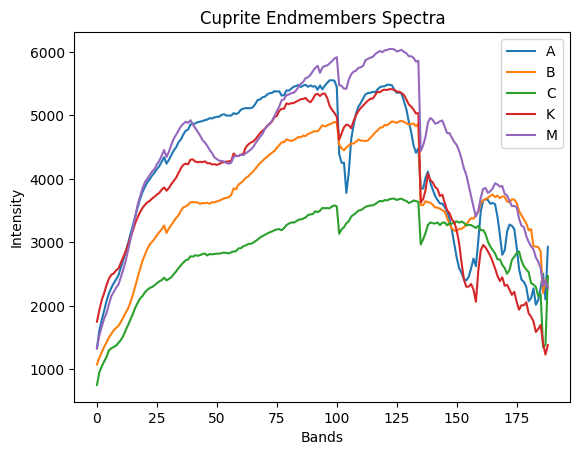

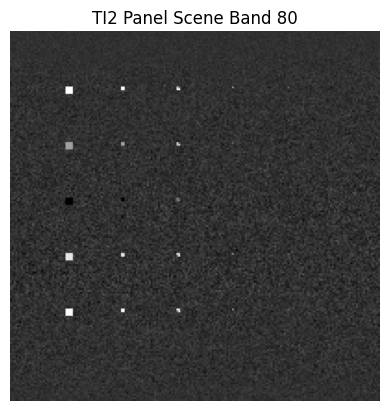

In [9]:
# Load the saved .mat file
data = loadmat('tite_reflectance.mat')

# Extract the variables
TI2 = data['TI2']
M = data['minerals']

# Plot endmembers
plt.figure()
for i in range(minerals.shape[1]):
    plt.plot(minerals[:, i], label=f'Mineral {i+1}')
plt.title("Cuprite Endmembers Spectra")
plt.xlabel("Bands")
plt.ylabel("Intensity")
plt.legend(["A", "B", "C", "K", "M"])
plt.show()

# Display #80 band of the TI2 image
plt.figure()
plt.imshow(TI2[:, :, 80], cmap='gray')
plt.axis('off')
plt.title(f'TI2 Panel Scene Band 80')
plt.show()